# Task 2: Coastal Flood Risk Assessment
Assessing the risk of sea level rise to the mangrove project.

In [17]:
# Install dependencies if needed
#!pip install -r requirements.txt

In [18]:
import geopandas as gpd
from shapely.geometry import mapping
import requests
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.windows import transform
from shapely.geometry import shape
from rasterio.transform import from_bounds
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
from rasterio.transform import from_origin

In [19]:
# data import
geojson_file_path = 'data_in/mangroves_case_study.geojson'
gmw_tiff_file_path = 'data_in/gmw_2020.tif' 
logo = mpimg.imread('data_in/logo.png')

#api
api_key = 'write_your_api_code_here'

## Import of geojson

In [20]:
# Load the GeoJSON with simplified geometries to avoid issues
geojson_data = gpd.read_file(geojson_file_path, ignore_geometry=False)

# Extract the geometry and ensure it's convertible to simpler shapes
geojson_geometry = geojson_data['geometry'].simplify(0.01, preserve_topology=True)

# Create a new GeoDataFrame with simplified geometry
simplified_geojson = gpd.GeoDataFrame(geojson_data, geometry=geojson_geometry)

# Get the bounding box of the simplified GeoJSON
bounding_box = simplified_geojson.total_bounds  

bounding_box
# [west, south, east, north]

array([0.68953617, 5.77372468, 0.82733105, 5.87476604])

## Use API to parce SRTMGL1 DEM (30 m)

In [21]:
west, south, east, north = bounding_box

# OpenTopography API request for SRTMGL1 data
  # Replace with your OpenTopography API key
url = (
    f"https://portal.opentopography.org/API/globaldem?"
    f"demtype=SRTMGL1&south={south}&north={north}&west={west}&east={east}&"
    f"outputFormat=GTiff&API_Key={api_key}"
)

# Step 2: Download and Save the DEM Data
response = requests.get(url)
DEM_raster = 'data_out/elevation_data.tif' 
# Check if the request was successful
if response.status_code == 200:
    with open(DEM_raster, 'wb') as f:
        f.write(response.content)
else:
    print("Failed to download DEM data.")

## Analysis

In [22]:
# Define boundary for cropping
geojson_boundary = geojson_data.boundary  # GeoJSON boundary

# Load the mangrove raster and crop with the GeoJSON boundary
with rasterio.open(gmw_tiff_file_path) as dataset:
    out_image, out_transform = mask(dataset, geojson_geometry, crop=True)
    

# Update metadata for the cropped raster
out_meta = dataset.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
})

In [23]:
# Step 1: Define Sea Level Rise and Open Elevation Data
sea_level_rise = 1.0  # Example value for sea level rise

with rasterio.open(DEM_raster) as elevation_dataset:
    elevation_data = elevation_dataset.read(1)  # Read the first band
    elevation_meta = elevation_dataset.meta.copy()  # Copy the metadata

# Step 2: Define Flood-Prone Areas
flood_prone_areas = (elevation_data <= sea_level_rise).astype(int)  # Create a binary array

# Step 3: Update Metadata for Output
# Update metadata to match the derived data
flood_meta = elevation_meta.copy()  # Use the original metadata as a base
flood_meta.update({
    "dtype": flood_prone_areas.dtype,  # Data type of the derived array
    "count": 1,  # Number of bands (1 for this case)
})

# Step 4: Export to GeoTIFF
flood_prone_raster = 'data_out/flood_prone_areas.tif' 

with rasterio.open(
    flood_prone_raster,
    'w',  # Write mode
    driver='GTiff',
    height=flood_prone_areas.shape[0],
    width=flood_prone_areas.shape[1],
    count=1,
    dtype=flood_prone_areas.dtype,
    crs=elevation_meta['crs'],  # Use the same CRS as the elevation dataset
    transform=elevation_meta['transform']  # Keep the same spatial reference
) as dst:
    dst.write(flood_prone_areas, 1)  # Write data to the first band

## Plotting

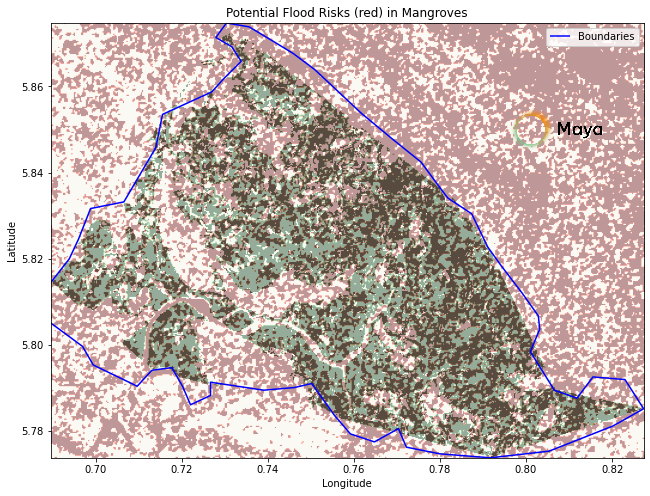

In [24]:
# Step 3: Plotting with GeoJSON Boundaries, Cropped Raster, and Flood Risks
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the flood-prone areas in red
plt.imshow(out_image[0], cmap='Greens', alpha=0.7, extent=[bounding_box[0], bounding_box[2], bounding_box[1], bounding_box[3]])

# Plot GeoJSON boundaries
geojson_data.boundary.plot(ax=ax, color='blue', label='Boundaries')

plt.imshow(flood_prone_areas, cmap='Reds', alpha=0.4, 
           extent=[bounding_box[0], bounding_box[2], bounding_box[1], bounding_box[3]])

x_coord = 0.808  # Adjust as needed
y_coord = 5.85  # Adjust as needed
zoom = 0.1  # Adjust as needed
imagebox = OffsetImage(logo, zoom=zoom)
ab = AnnotationBbox(imagebox, (x_coord, y_coord), frameon=False)
ax.add_artist(ab)

# Plot settings
ax.set_title('Potential Flood Risks (red) in Mangroves')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.show()

## In-depth analysis

In [25]:
geojson_boundary = gpd.read_file(geojson_file_path)

# Read the raster data
with rasterio.open(DEM_raster) as src:
    # Use the GeoJSON boundary to crop the raster
    # The 'mask' function returns the cropped data and the new transform
    cropped_data, cropped_transform = mask(src, geojson_boundary.geometry, crop=True)

    # Define output file for the cropped data
    output_path_cropped_DEM = "data_out/cropped_elevation_data.tif"

    # Write the cropped raster to a new GeoTIFF file
    with rasterio.open(
        output_path_cropped_DEM,
        'w',
        driver='GTiff',
        height=cropped_data.shape[1],
        width=cropped_data.shape[2],
        count=src.count,
        dtype=cropped_data.dtype,
        crs=src.crs,
        transform=cropped_transform
    ) as dst:
        # Write the data for each band
        for band in range(1, src.count + 1):
            dst.write(cropped_data[band - 1], band)

In [26]:
# Step 1: Read the GeoJSON boundary
geojson_boundary = gpd.read_file(geojson_file_path)

# Step 2: Read the raster data
with rasterio.open(gmw_tiff_file_path) as src:
    # Step 3: Use the GeoJSON boundary to crop the raster
    # The 'mask' function returns the cropped data and the new transform
    cropped_data, cropped_transform = mask(src, geojson_boundary.geometry, crop=True)

    # Step 4: Define output file for the cropped data
    output_path_aoi_mask_2020 = "data_out/aoi_mask_gmw_2020.tif"

    # Step 5: Write the cropped raster to a new GeoTIFF file
    with rasterio.open(
        output_path_aoi_mask_2020,
        'w',
        driver='GTiff',
        height=cropped_data.shape[1],
        width=cropped_data.shape[2],
        count=src.count,
        dtype=cropped_data.dtype,
        crs=src.crs,
        transform=cropped_transform
    ) as dst:
        # Write the data for each band
        for band in range(1, src.count + 1):
            dst.write(cropped_data[band - 1], band)

In [27]:
# Open the flood-prone areas GeoTIFF
with rasterio.open('data_out/flood_prone_areas.tif') as flood_src:
    # Get data and metadata
    flood_data = flood_src.read(1)
    flood_meta = flood_src.meta

# Open the AOI mask GeoTIFF
with rasterio.open('data_out/aoi_mask_gmw_2020.tif') as aoi_src:
    # Get the original AOI data and metadata
    aoi_data = aoi_src.read(1)
    aoi_meta = aoi_src.meta

    # Reproject the AOI mask to align with the flood-prone areas
    new_transform, new_width, new_height = calculate_default_transform(
        aoi_meta['crs'], flood_meta['crs'], aoi_src.width, aoi_src.height, *aoi_src.bounds
    )

    # Create a new resampled dataset to hold the AOI data
    aoi_resampled_data = np.empty((1, flood_meta['height'], flood_meta['width']), dtype=np.uint8)

    reproject(
        source=aoi_data,
        destination=aoi_resampled_data,
        src_transform=aoi_meta['transform'],
        dst_transform=flood_meta['transform'],
        src_crs=aoi_meta['crs'],
        dst_crs=flood_meta['crs'],
        resampling=Resampling.nearest,
    )

# Calculate the overlap
overlap_data = np.where((flood_data > 0) & (aoi_resampled_data[0] > 0), 1, 0)

# Define metadata for the output GeoTIFF
overlap_meta = flood_meta.copy()
overlap_meta.update({
    'count': 1,
    'dtype': 'uint8',
})

# Save the new GeoTIFF with the calculated overlap
with rasterio.open('data_out/aoi_flood_prone_areas.tif', 'w', **overlap_meta) as dst:
    dst.write(overlap_data, 1)

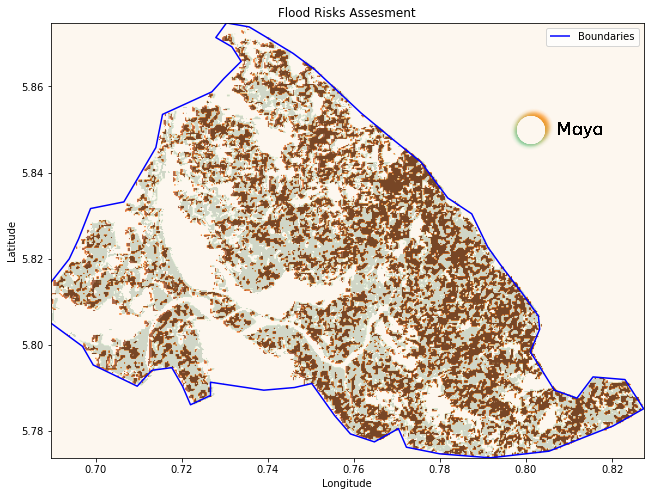

In [28]:
# Step 3: Plotting with GeoJSON Boundaries, Cropped Raster, and Flood Risks
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the flood-prone areas in red
plt.imshow(aoi_data, cmap='Greens', alpha=0.6, extent=[bounding_box[0], bounding_box[2], bounding_box[1], bounding_box[3]])

# Plot GeoJSON boundaries
geojson_data.boundary.plot(ax=ax, color='blue', label='Boundaries')

plt.imshow(overlap_data, cmap='Oranges', alpha=0.7, 
           extent=[bounding_box[0], bounding_box[2], bounding_box[1], bounding_box[3]])

#logo
x_coord = 0.808  
y_coord = 5.85 
zoom = 0.1
imagebox = OffsetImage(logo, zoom=zoom)
ab = AnnotationBbox(imagebox, (x_coord, y_coord), frameon=False)
ax.add_artist(ab)

# Plot settings
ax.set_title('Flood Risks Assesment')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.show()

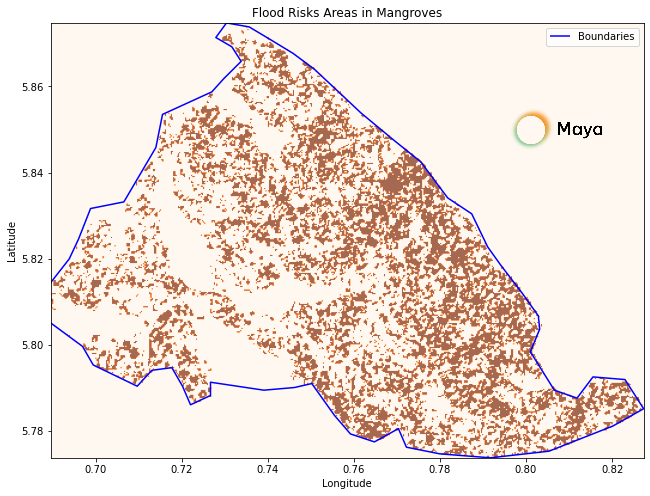

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

geojson_data.boundary.plot(ax=ax, color='blue', label='Boundaries')

plt.imshow(overlap_data, cmap='Oranges', alpha=0.7, 
           extent=[bounding_box[0], bounding_box[2], bounding_box[1], bounding_box[3]])

#logo
x_coord = 0.808  
y_coord = 5.85  
zoom = 0.1 
imagebox = OffsetImage(logo, zoom=zoom)
ab = AnnotationBbox(imagebox, (x_coord, y_coord), frameon=False)
ax.add_artist(ab)

ax.set_title('Flood Risks Areas in Mangroves')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

## Ways to improve

# CODE
- use as .py file with functions to have easier setup of options what to export and other
- add feature with proximity-based to nearest water body risk system (non binary)

# Ready solutions
https://github.com/DahnJ/REM-xarray/blob/master/rem-in-xarray-tutorial.ipynb
https://github.com/mbforr/youtube-examples/blob/main/relative-elevation-model/rem-in-xarray-tutorial.ipynb
https://youtu.be/EOzovrGOaJE?si=opwGhhJLu4Y-3gsX

# DATA
- hydrology, land use, and coastal features
- high-resolution and accurate DEM data
- satellite altimetry data to track sea-level trends
- NOAA Sea Level Rise Data Download (US - more precise)

# Other software
- Use InaSAFE QGIS plugin
- FloodRisk 2 QGIS plugin
- GEE models (https://www.mdpi.com/2073-4441/13/21/3115)
- ArcPy / ArcGIS Pro Toolbox (https://www.scirp.org/journal/paperinformation?paperid=119148)
- spatial reduction and reconstruction (SRR) method (https://www.sciencedirect.com/science/article/pii/S2215016121003204; https://github.com/yuerongz/SRR-method)
- Google Flood Forecasting (https://sites.research.google/floodforecasting/, up to 7 days in advance, https://arxiv.org/abs/2307.16104)
- Good literature review for Nepal case - better DEM, other input data and models (https://www.mdpi.com/2072-4292/14/22/5660#B193-remotesensing-14-05660)